In [45]:
from IPython.display import display,HTML
display(HTML("<style>.container {width:95% !important ; }</style>"))

# packages

In [188]:
from matplotlib import font_manager
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor



# font_manager.get_font_names() 전체 폰트이름 확인
# 맥의 경우 AppleGothic
# 고딕이나 나눔 관련한 폰트 입력하면됨
plt.rc('font',family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False # 음수

# ADP 27회 실기 문제

# 문제설명 (1번)
- 데이터 url :https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/rauds.csv    
- 출처 :https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud (후처리)    
신용카드 사용에 대한 데이터이다. 각 컬럼의 의미는 다음과 같다.    
Time : 카드 이용 시점의 시각 (sec)    
V1 ~ V25 : 유저 특성에 관한 피쳐 (float)    
Amount : 거래금액    
Class : 0: 정상거래 , 1: 이상거래

## 문제 1-1 
EDA 데이터 탐색 (시각화 포함)

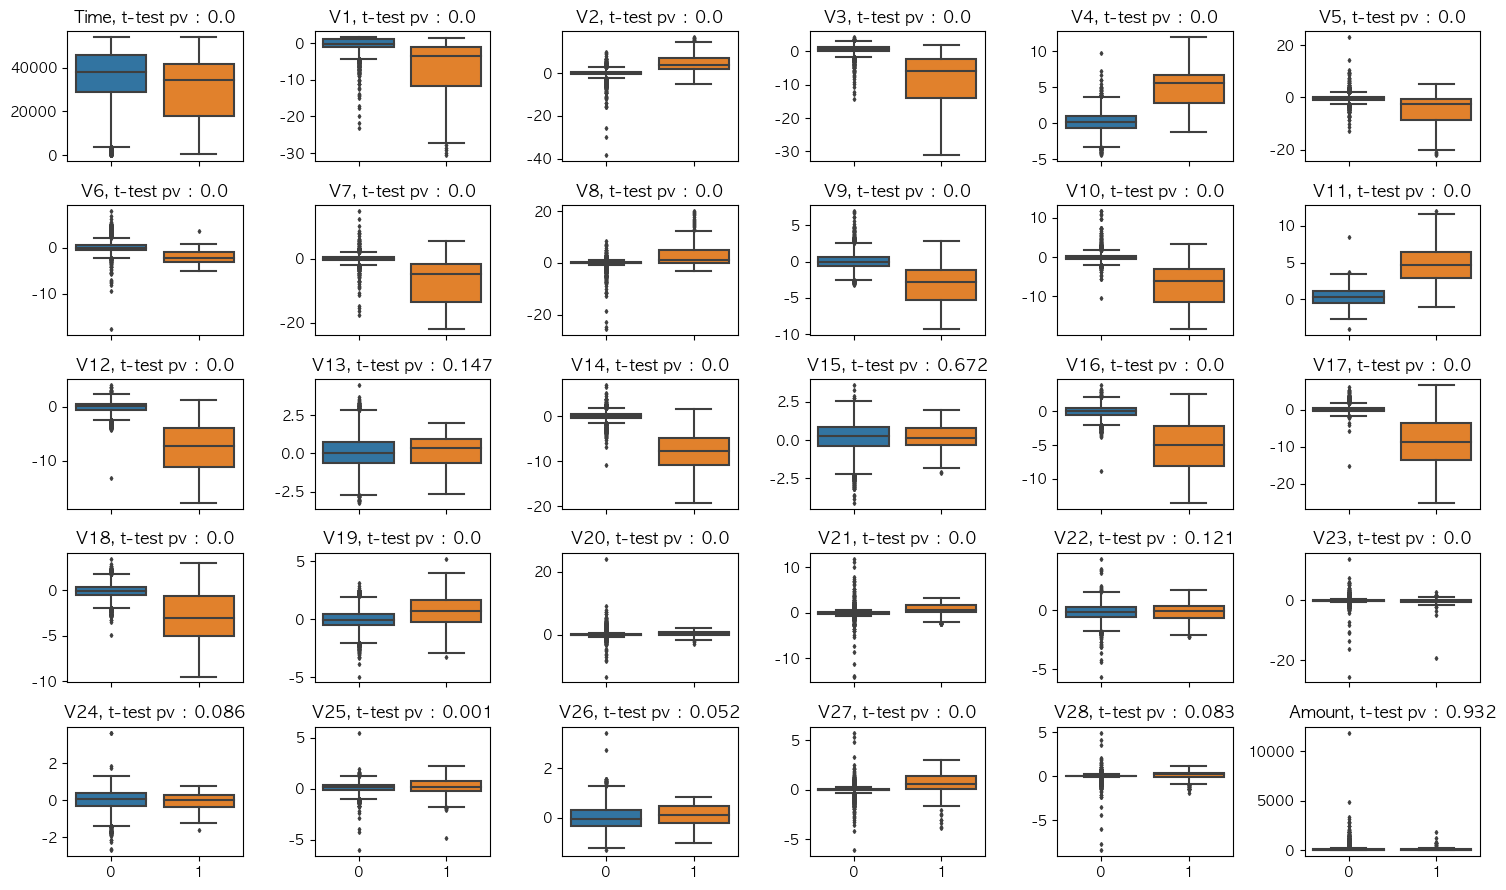

Class,0,1
count,5723,177


In [106]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/rauds.csv')

lst = []
fig,ax = plt.subplots(5,6,figsize=(15,9),sharex=True)
for i, col in enumerate(df.drop(columns =['Class']).columns):
    
    target = df[[col,'Class']]
    
    
    s,p =ttest_ind(target.query('Class ==0')[col],target.query('Class ==1')[col])
    lst.append([col,p])
    sns.boxplot(data = target,x = 'Class',y = col,ax = ax.flat[i],flierprops={'markersize':2})
    ax.flat[i].set_ylabel('')
    ax.flat[i].set_xlabel('')
    ax.flat[i].set_title(col + f', t-test pv : {round(p,3)}')
    
fig.tight_layout()
plt.show()


display(df.Class.value_counts().to_frame().T)

## 문제 1-2 
변수간 상관관계를 시각화하고 전처리가 필요하다면 그 이유를 설명하고 시행하라

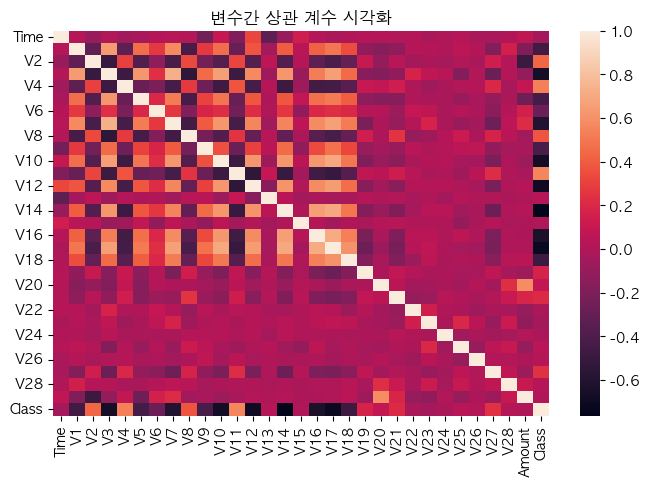


변수간 상관계수 시각화를 했을 때 V19 이상의 숫자를 가진 컬럼들 간의 상관성은 낮은 것으로 보인다.
각변수의 VIF값을 계산하고 10이상을 가지는 컬럼을 다중공선성이 있다 판단하고 제거하는 전처리를 시행한다. 
해당 컬럼은 V2,V7,Amount컬럼이다. 



In [191]:
fig,ax = plt.subplots(1,figsize=(8,5))
sns.heatmap(df.corr(),ax=ax)
ax.set_title('변수간 상관 계수 시각화')
plt.show()



X = df.drop('Class', axis=1)  
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data[vif_data.VIF >10].reset_index(drop=True)


df_pre =df.drop(columns =['V2','V7','Amount'])
print('''
변수간 상관계수 시각화를 했을 때 V19 이상의 숫자를 가진 컬럼들 간의 상관성은 낮은 것으로 보인다.
각변수의 VIF값을 계산하고 10이상을 가지는 컬럼을 다중공선성이 있다 판단하고 제거하는 전처리를 시행한다. 
해당 컬럼은 V2,V7,Amount컬럼이다. 
''')

## 문제 2.1 
차원축소 방법 2가지 이상에 대해 설명하고 장단점을 비교하라

1. pca
 - 장점 : 
     - 주성분은 데이터의 변동성을 최대화하는 방향으로 정의되어 데이터의 중요한 특징을 잘 찾아낸다.
     - 선형 변환을 통해 계산하므로 효율적이고 주성분의 중요도를 파악하는데 용이하다.
 - 단점 :
     - 작은 분산을 가지는 성분 무시 될 가능성 높음
     - 비선형 특성을 파악하기 어렵다
     
2. t-sne
- 장점
    - 비선형 구조나 군집을 잘 표현할 수 있다.
    - 이웃 데이터 간 거리를 고려하므로 군집 시각화가 용이하다.
- 단점
    - 변수간 관계 해석 어렵다
    - 계산이 오래걸린다.

## 문제 2.2
2.1에서 선택한 한가지 차원축소 방법을 실제로 수행하고 선택한 이유를 설명하라

,explained_variance,cumsum
PC1,0.256507,0.256507
PC2,0.060822,0.317328
PC3,0.052016,0.369344
PC4,0.048803,0.418147
PC5,0.045095,0.463241



1번에서 전처리한 데이터를 바탕으로 정규화를 진행한 후 PCA를 진행했다. 
PCA를 선택한 이유는 주축의 분산설명력을 확인 할 수 있기 때문이다.    
주축의 숫자에 따른 분산설명력과 누적합에 대한 데이터프레임을 구하고 19개의 주축이 있을경우 90%의 데이터를 설명할 수 있다는 것을 확인 했다.    



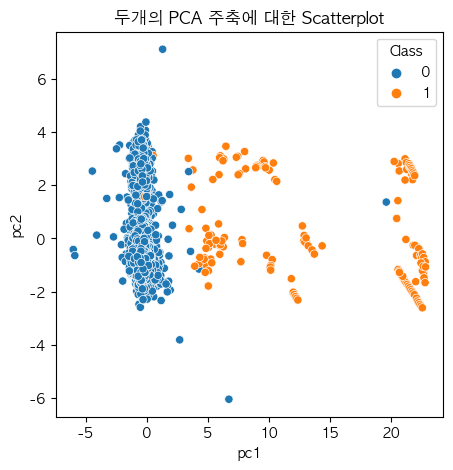

두개의 PCA 주축에 대해 scatterplot을 뿌려보면 Class별로 군집이 나누어 지는 것을 확인 할 수 있다.


In [252]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X = df_pre.drop(columns =['Class'])
y = df_pre['Class']

ss = StandardScaler()
pca = PCA()

scaled_df = ss.fit_transform(X)

pca_df = pca.fit_transform(scaled_df)
exp_df = pd.DataFrame(pca.explained_variance_ratio_,columns =['explained_variance'])
exp_df['cumsum'] = exp_df['explained_variance'].cumsum()
exp_df.index = ['PC' + str(i) for i in range(1,len(exp_df)+1)]
col_idx = exp_df[exp_df['cumsum']>=0.9].index[0]

pca_df_filter = pca_df[:,:np.where(exp_df.index== col_idx)[0][0] +1 ]

display(exp_df.head())
print('''
1번에서 전처리한 데이터를 바탕으로 정규화를 진행한 후 PCA를 진행했다. 
PCA를 선택한 이유는 주축의 분산설명력을 확인 할 수 있기 때문이다.    
주축의 숫자에 따른 분산설명력과 누적합에 대한 데이터프레임을 구하고 19개의 주축이 있을경우 90%의 데이터를 설명할 수 있다는 것을 확인 했다.    
''')

fig,ax = plt.subplots(1,figsize=(5,5))
sns.scatterplot(data = pd.DataFrame(pca_df_filter[:,:2],columns =['pc1','pc2']), x = 'pc1', y= 'pc2',hue = df_pre.Class,ax=ax)
ax.set_title('두개의 PCA 주축에 대한 Scatterplot')
plt.show()

print('두개의 PCA 주축에 대해 scatterplot을 뿌려보면 Class별로 군집이 나누어 지는 것을 확인 할 수 있다.')

## 문제 3.1
오버샘플링과 언더샘플링에 대한 설명 및 장단점을 설명하라

두 샘플링 기법 모두 데이터 불균형 문제를 해결하기 위한 방법이다.     
오버 샘플링은 부족한 클래스의 데이터를 추가로 샘플링 하는 방법이다.     
단순 복원샘플링 방식이나 주어진 데이터 사이의 가상 데이터 방식의 샘플링 방식인 SMOTE 방식이 존재한다.      
- 장점 : 소수 클래스의 패턴 학습에 도움을 줄 수 있다.
- 단점 : 과적합 문제 발생 할 수 있음

언더 샘플링은 다수 클래스의 데이터를 줄여서 클래스간 불균형을 해결하는 방식이다.
- 장점 : 클래스 불균형 문제 완화 / 모델 학습 향상
- 단점 : 다수 클래스 정보 손실

## 문제 3.2 
오버샘플링 및 언더샘플링 방식 중 하나를 선택하여 구현하고 Class를 종속변수로 하는 분류 모델을 2가지 이상 구현하고 성능을 비교하라

In [286]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


rf =RandomForestClassifier(random_state=1)
lr = LogisticRegression()

# train,test 분리 후 train에 대해서 오버샘플링을 진행하고 결과를 도출한다.
x_train,x_test  ,y_train,y_test = train_test_split(pca_df_filter,df['Class'],random_state=1,test_size=0.3)

smote = SMOTE(random_state=1)
x_train_resample , y_train_resample = smote.fit_resample(x_train,y_train)

# smote 샘플링
rf.fit(x_train_resample,y_train_resample)
lr.fit(x_train_resample,y_train_resample)
pred_rf = rf.predict(x_test)
pred_lr = lr.predict(x_test)
f1_rf_smote = f1_score(y_test,pred_rf)
f1_lr_smote = f1_score(y_test,pred_lr)

train_rf_smote_model_score = rf.score(x_train_resample,y_train_resample)
train_lr_smote_model_score = lr.score(x_train_resample,y_train_resample)


# 원본데이터 
rf.fit(x_train,y_train)
lr.fit(x_train,y_train)
pred_rf = rf.predict(x_test)
pred_lr = lr.predict(x_test)
f1_rf_org = f1_score(y_test,pred_rf)
f1_lr_org = f1_score(y_test,pred_lr)

train_rf_model_score = rf.score(x_train,y_train)
train_lr_model_score = lr.score(x_train,y_train)


result = pd.DataFrame([[f1_rf_smote,f1_lr_smote],[f1_rf_org,f1_lr_org]],columns =['RandomForest','LogisticRegression'])
result.index = ['SMOTE_sample','Origin_sample']
result.index.name ='f1_score'

result.loc['SMOTE_model_train_score','RandomForest'] = train_rf_smote_model_score
result.loc['SMOTE_model_train_score','LogisticRegression'] = train_lr_smote_model_score

result.loc['Origin_model_train_score','RandomForest'] = train_rf_model_score
result.loc['Origin_model_train_score','LogisticRegression'] = train_lr_model_score

result = result.round(3)
display(result)

print('''
PCA 및 분산설명력으로 컬럼 제한을 한 전처리 완료 된 데이터를 학습데이터로 한다.   
train,test 셋을 7:3으로 구분하고 train셋에 대해서 SMOTE방식의 오버 샘플링을 진행한다.   
분류모델은 랜덤포레스트와 로지스틱 회귀를 진행한다. 두가지 모델에 대해 오버샘플링 시행 샘플과 원본 샘플 각각 모델링을 진행한 후
test셋에 대해 예측값과의 f1스코어를 추출한게 위의 데이터프레임이다. 
smote방식이 오버샘플링 하지 않은 원본 데이터 보다 f1 값이 낮게 나왔다. smote방식의 학습 데이터에 대한 모델 스코어는 1로 이는 과적합이 발생했다고 볼 수 있다.
''')

,RandomForest,LogisticRegression
f1_score,,
SMOTE_sample,0.876,0.623
Origin_sample,0.918,0.920
SMOTE_model_train_score,1.000,0.954
Origin_model_train_score,1.000,0.996



PCA 및 분산설명력으로 컬럼 제한을 한 전처리 완료 된 데이터를 학습데이터로 한다.   
train,test 셋을 7:3으로 구분하고 train셋에 대해서 SMOTE방식의 오버 샘플링을 진행한다.   
분류모델은 랜덤포레스트와 로지스틱 회귀를 진행한다. 두가지 모델에 대해 오버샘플링 시행 샘플과 원본 샘플 각각 모델링을 진행한 후
test셋에 대해 예측값과의 f1스코어를 추출한게 위의 데이터프레임이다. 
smote방식이 오버샘플링 하지 않은 원본 데이터 보다 f1 값이 낮게 나왔다. smote방식의 학습 데이터에 대한 모델 스코어는 1로 이는 과적합이 발생했다고 볼 수 있다.



## 문제 4.1 
Class 컬럼이 주어지지 않았다고 가정하고 비지도 학습 방식의 이상탐지 모델을 만들려고한다.     
이상 탐지 모델 2가지 이상 기술하고 장단점을 설명하라

Isolation Forest 
- from sklearn.ensemble import IsolationForest   

OneClassSVM
- from sklearn.svm import OneClassSVM    

DBSCAN  
- from sklearn.cluster import DBSCAN / 이상치는 자동으로 -1으로 분류됨     

LocalOutlierFactor
- from sklearn.neighbors import LocalOutlierFactor    

AutoEncoder    
- 딥러닝 / keras나 pytorch로 구현 , from sklearn.neural_network import MLPRegressor 로 가능하지만 파라미터 다양하게 변화시키기에는 한계 있음

## 문제 4.2 
2번에서 만든 데이터로 한 가지 비지도학습 이상탐지 모델을 구현하고, 3번에서 만든 모델과 결과를 비교하라

In [304]:
from sklearn.ensemble import IsolationForest


isf = IsolationForest(random_state=1)
isf.fit(x_train_resample)
pred = pd.Series(isf.predict(x_test)).map({1:0,-1:1}) # 1 정상 , -1 비정상
isf_f1score =f1_score(y_test,pred)

print(f'''
Isolation Forest를 활용하여 학습하고 3번모델과 결과를 비교한다.    
3번에서 정의한 SMOTE 오버샘플링을 진행한 데이터로 학습하고 test셋으로 평가 했을 경우    
f1스코어는 {round(isf_f1score,3)} 이다. 이는 랜덤포레스트 f1 : 0.876, 로지스틱 회귀 f1 : 0.623 보다 낮은 수치이다.
''')


Isolation Forest를 활용하여 학습하고 3번모델과 결과를 비교한다.    
3번에서 정의한 SMOTE 오버샘플링을 진행한 데이터로 학습하고 test셋으로 평가 했을 경우    
f1스코어는 0.37 이다. 이는 랜덤포레스트 f1 : 0.876, 로지스틱 회귀 f1 : 0.623 보다 낮은 수치이다.



## 문제 5
2년 전 제품 생산량이 100,000개, 1년 전 제품 생산량이 150,000개, 그 후 팩토리 기술의 상승으로 제품 생산량이 250,000개 되었을 때, 연평균 상승률의 대푯값을 구하시오. (반올림하여 소수점 아래 둘째자리까지 표기하시오.)

## 문제 6
12건의 광고 시간 측정. 평균 15.5초, 분산 3.2초 일때 90% 신뢰구간은?

In [311]:
from scipy import stats

mean = 15.5
variance = 3.2
sample_size = 12
confidence_level = 0.90

# 표준편차 계산
std_dev = np.sqrt(variance)

# t-분포에서의 t-값 계산 (상위 5% 위치에 해당하는 값)
t_value = stats.t.ppf(1 - (1 - confidence_level) / 2, df=sample_size - 1)

margin_of_error = t_value * (std_dev / math.sqrt(sample_size))
confidence_interval_lower = mean - margin_of_error
confidence_interval_upper = mean + margin_of_error

print("샘플수가 적으므로 t분포를 사용하여 신뢰구간을 구한다. 그 하한 상한 값은 다음과 같다",(confidence_interval_lower, confidence_interval_upper))

샘플수가 적으므로 t분포를 사용하여 신뢰구간을 구한다. 그 하한 상한 값은 다음과 같다 (14.572609067393861, 16.427390932606137)


## 문제 설명 (7번)
강의 상류와 하류의 생물 다양성 점수에 차이가 있는지 검정하시오. (단, 같은 강에서 상류와 하류는 서로 독립적이지 않으며, 종속적인 관계에 있다.)

- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/river.csv

## 문제 7.1
귀무가설과 대립가설을 세우시오

귀무가설 : 강의 상류와 하류의 생물 다양성 점수에는 차이가 없다.        
대립가설 : 강의 상류와 하류의 생물 다양성 점수에는 차이가 있다.        

## 문제 7.2
검정통계량 및 유의확률을 구하고 검정 결과를 서술하시오

In [317]:
from scipy.stats import ttest_rel
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/river.csv')

s,p = ttest_rel(df['up'],df['down'])

print(f'''
강의 상류와 하류는 독립적이지 않으므로 대응표본 t검정을 시행한다. 검정 통계량은 {round(s,3)}이고 유의확률은 {round(p,3)}이다.
유의수준 0.05하에서 귀무가설을 기각 할수 없다. 즉 강의 상류와 하류의 생물 다양성 점수에는 차이가 없다.
''')


강의 상류와 하류는 독립적이지 않으므로 대응표본 t검정을 시행한다. 검정 통계량은 1.292이고 유의확률은 0.213이다.
유의수준 0.05하에서 귀무가설을 기각 할수 없다. 즉 강의 상류와 하류의 생물 다양성 점수에는 차이가 없다.



## 문제설명(8번)
user_counts를 종속변수로 하는 데이터이다

- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/problem8.csv

## 문제 8.1
분위수 회귀분석 (Quantile Regression) 을 사용하여 회귀 계수를 구하시오. (반올림하여 소수점 아래 둘째자리까지 표기하시오.)

In [34]:
from statsmodels.api import QuantReg
import numpy as np

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/problem8.csv')


quantile = 0.5
X = sm.add_constant(df.drop(columns =['user_counts']))  # 상수항 추가
model = sm.QuantReg(df['user_counts'], X)
result = model.fit(q=quantile)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:            user_counts   Pseudo R-squared:               0.3723
Model:                       QuantReg   Bandwidth:                       840.9
Method:                 Least Squares   Sparsity:                        5590.
Date:                Sat, 26 Aug 2023   No. Observations:                 2097
Time:                        17:58:50   Df Residuals:                     2093
                                        Df Model:                            3
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5941.8395    198.127     29.990      0.000    5553.293    6330.386
temperature     268.8920      6.571     40.918      0.000     256.005     281.779
wind           -129.4050     46.259     -2.797      0.005    -220.124     -38.686
precipitation   -83.3843      7.891    -10.567      0.000     -98.859     -67.910
=================================================================================
"""

## 문제 8.2
8.1의 모델의 회귀계수를 활용하여 temperature : 10.5 , wind : 8.2 , precipitation : 3.5 일때 user_counts를 예측하시오 

In [39]:
# 회귀 계수 활용 예측
pram = result.params.values
pred_v = np.array([1,10.5,8.2,3.5])
pred =sum(pram * pred_v)


# 모델 클래스에서 바로  예측
pred = result.predict(pred_v )[0]
print(pred)

7412.239537260735


## 문제설명(9번)
지하철 호선과 월별, 승객 수 간 상관관계가 있는지 확인(Type III Anova 사용)

- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/subway.csv

## 문제 9.1 
귀무가설과 대립가설 설정하라

귀무가설 :      
대립가설 : 

## 문제 9.2
통계량을 구하고 검정 결과를 서술하라

In [8]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/27/subway.csv')



# 다중 선형 회귀 모델 정의
model = ols('total ~ line + month + line*month', data=df).fit()

# Type III ANOVA 실행
type3_anova = sm.stats.anova_lm(model, typ=3)
type3_anova

,sum_sq,df,F,PR(>F)
Intercept,4.993217e+06,1.0,497.746547,1.281602e-25
line,3.173160e+03,1.0,0.316315,5.766850e-01
month,2.118582e+04,1.0,2.111898,1.532533e-01
line:month,2.115084e+03,1.0,0.210841,6.483694e-01
Residual,4.413924e+05,44.0,NaN,NaN


참고사이트 
- https://blog.naver.com/clairefromkorea/222938928665
- https://amaruak00.github.io/2022/12/17/adp27th.html
- https://blog.naver.com/dmz04/222938757841